In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.stats import binned_statistic

In [206]:
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
col_names = ['NZGDID', 'depth', 'qc', 'fs', 'u2']
#depth is in meter.
#qc, fs, and u2 are in MPa.
df = pd.read_csv('CPT_Data_20160323_plus_trench.csv', names=col_names)
print(f'The data includes {len(df.NZGDID.unique())} CPT soundings')

The data includes 9243 CPT soundings


In [3]:
metadata = pd.read_csv('CPT_Metadata.csv')
print(f'{len(metadata)} CPT data are selected')
metadata.head()
df = df[df.NZGDID.isin(metadata.CPT)]

1702 CPT data are selected


CPT Metadata - ROI, in master data file, and min depth req.csv:
The file you are referring to is a file that has the metadata for each of the CPT points in the database that we deemed "useful."  Multiple CPTs were filtered out based on certain criteria including the following:  must be within region of interest, CPT data file must be available in the master data file, CPT depths must be at least 2H deep and the predrill depth must not exceed the ground water table depth.

The metadata it has includes CPT ID numbers from the NZGD, the predrill depth, the distance from the free face to the CPT (L), the total depth of the sounding, the GWT depth, the PGA at the CPT location, the lat and long of the CPT, the EW, NS, and amplitude displacements (modified manually when necessary) from Rathje et al. 2017, the Rrup values, the elevation of the CPT in msl, an approximate ground slope calculated from a 5 m LIDAR grid, and the azimuth direction of the river from the CPT in degrees.  The LDI values can be disregarded as they are depth dependent and not very useful except for getting a quick idea of how liquefiable the soil there is.  There are headers on the csv so you know which column has which data value.

The file named CPT_Data_2016.0323_plus_trench.csv has the actual CPT data organized in 5 columns.  Column 1 is the NZGD ID number for the CPT.  Column 2 is the depth (m) of the data point.  Column 3 is tip resistance, qc (MPa).  Column 4 is sleeve friction, fs (MPa) Column 5 is the pore water pressure, u (kPa).

In [4]:
# round the depth values to 0.01m
df.depth = df.depth.round(decimals=2)
# set min caps for qc and fs
df.qc = df.qc.clip(lower = 0.01, upper = None)
df.fs = df.fs.clip(lower = 0.001, upper = None)

# change qc, fs, u2 into kPa unit
df.qc *= 1000
df.fs *= 1000

Calculate the approximated unit weight based on Robertson and Cabal 2010

In [5]:
pa = 101 # atmospheric pressure in kPa
gamma_w = 9.81 # unit weight of water

## Unit weight estimation
![alt text](approximate_gamma.png)

In [6]:
gamma = gamma_w*(0.27*(np.log10(100*df.fs/df.qc)) + 0.36*(np.log10(df.qc/pa)) + 1.236)
gamma = np.clip(gamma, a_min=1.5*gamma_w, a_max=2.0*gamma_w)
# should we consider upper and lower caps for estimated gamma?
df['gamma'] = gamma
print(f'min gamma: {gamma.min():.2f} kN/m^3')
print(f'max gamma: {gamma.max():.2f} kN/m^3')


min gamma: 14.71 kN/m^3
max gamma: 19.62 kN/m^3


## Ic and qc1ncs calculation
![alt text](Ic_qc1ncs.png)

In [7]:
def CPT_interpret(qc, fs, gamma, depth, GWT):
    
    total_stress = integrate.cumtrapz(gamma, depth, initial=0)
    #total_stress = gamma*depth
    u = gamma_w * np.clip((depth - GWT), a_min=0, a_max=None)
    eff_stress = total_stress - u

    n_new = np.ones(len(qc))
    n_old = np.zeros(len(qc))
    # this was determined through trial and error with the entire database,
    # smaller values lead to convergence issues with some of the CPTs
    isConverge = True
    iteration = 0
    while np.any(abs(n_new - n_old) > 0.003) == 1:
        n_old = n_new
        F = np.clip(100*fs/(qc - total_stress), a_min=0, a_max=None)
        
        Q = np.clip((qc-total_stress)/pa * np.power(pa/eff_stress, n_new), a_min=0, a_max=None)
        #Q = np.multiply((qc - total_stress) / pa, np.power(pa / eff_stress, n_new))
        Ic = np.sqrt((3.47 - np.log10(Q))**2 + (1.22 + np.log10(F))**2)
        Ic = np.real(Ic)
        n_new = 0.3 * (Ic-1.64) + 0.5
        n_new[Ic <= 1.64] = 0.5
        n_new[(Ic >= 3.3) | (n_new > 1.0)] = 1.0
        n_new[eff_stress > 300] = 1
        iteration+=1
        if iteration > 30:
            print('not converging')
            isConverge = False
            break

    # 0.07 is the curve fitting parameter used by Robinson et al 2013 for liquefiable soils along
    # the Avon River in Christchurch, New Zealand
    FC = 80 * (Ic + 0.07) - 137
    FC[FC < 0] = 0
    FC[FC > 100] = 100

    # procedure for calculating the normalized tip resistance (qc1n) and clean sand corrected normalized tip resistance (qc1ncs)
    # from Boulanger and Idriss 2014
    m = 0.7
    Cn = np.clip((pa/eff_stress)**m, a_min=None, a_max=1.7)
    qc1n = Cn*qc/pa
    delta_qc1n = (11.9 + qc1n/14.6)*np.exp(1.63 - 9.7/(FC+2) - (15.7/(FC+2))**2)
    qc1ncs_new = qc1n + delta_qc1n
    qc1ncs_old = np.zeros(len(qc))

    while np.any(abs(qc1ncs_new-qc1ncs_old) > 0.0001) == 1:
        qc1ncs_old = qc1ncs_new
        m = 1.338 - 0.249 * qc1ncs_new**0.264
        Cn = np.clip((pa/eff_stress)**m, a_min=None, a_max=1.7)
        qc1n = Cn*qc/pa
        delta_qc1n = (11.9 + qc1n/14.6)*np.exp(1.63 - 9.7/(FC+2) - (15.7/(FC+2))**2)
        qc1ncs_new = np.clip((qc1n + delta_qc1n), a_min=21, a_max=254)
    qc1ncs = qc1ncs_new
    
    return qc1ncs, Ic, isConverge

In [8]:
df['qc1ncs'] = 0
df['Ic'] = 0

In [9]:
for row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    ID = row[1]['CPT']
    GWT = row[1]['GWT (m)']
    qc1ncs, Ic, isConverge = CPT_interpret(df.qc[df.NZGDID==ID],
                               df.fs[df.NZGDID==ID],
                               df.gamma[df.NZGDID==ID],
                               df.depth[df.NZGDID==ID],
                               GWT=GWT)
    if not isConverge:
        print(f'ID: {ID}')
    df.loc[df.NZGDID==ID,'qc1ncs'] = qc1ncs
    df.loc[df.NZGDID==ID,'Ic'] = Ic

  0%|          | 0/1702 [00:00<?, ?it/s]

D:\Anaconda\envs\Lateraldispl\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [88]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

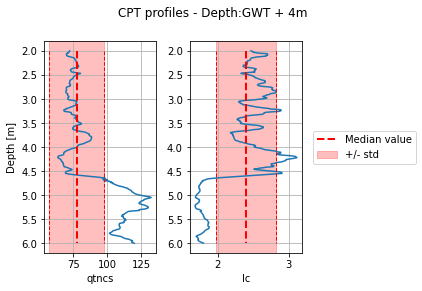

qtcns median (std) is 77.41 (20.26)
Ic median (std) is 2.40 (0.42)


In [10]:
ID = 4
mask = (df.depth[df.NZGDID==ID]>=2) & (df.depth[df.NZGDID==ID]<=6)
#create dataset with dimensionless quantities
#d = {'Depth': depth, 'Fr': F, 'Qtn':qc1n ,'Qtn_cs':qc1ncs, 'Ic':Ic}
d = {'Depth': df.depth[df.NZGDID==ID][mask], 'Qtn_cs':df.qc1ncs[df.NZGDID==ID][mask], 'Ic':df.Ic[df.NZGDID==ID][mask]}

CPT_data = pd.DataFrame(data=d)

Depth=CPT_data.values[:,0]
Qtncs=CPT_data.values[:,1]
Ic=CPT_data.values[:,2]

stat = CPT_data.agg(['median','std'])
Qtncs_med = stat.values[0,1]
Qtncs_std = stat.values[1,1]
Ic_med = stat.values[0,2]
Ic_std = stat.values[1,2]

Qtncs_val = [Qtncs_med - Qtncs_std, Qtncs_med + Qtncs_std]
y = [Depth[0], Depth[-1]]

Q_pl = [Qtncs_med,Qtncs_med]
Q_pl_min = [Qtncs_med - Qtncs_std,Qtncs_med - Qtncs_std]
Q_pl_max = [Qtncs_med + Qtncs_std,Qtncs_med + Qtncs_std]

Ic_pl = [Ic_med,Ic_med]
Ic_pl_min = [Ic_med - Ic_std,Ic_med - Ic_std]
Ic_pl_max = [Ic_med + Ic_std,Ic_med + Ic_std]

plt.subplots(tight_layout=True)

plt.subplot(121)
plt.plot(Qtncs,Depth)# plotting the initial datapoints 
plt.plot(Q_pl,y, color ='red', linestyle='dashed',linewidth=2)
plt.plot(Q_pl_min,y, Q_pl_max, y, color ='red', linestyle='dashed',linewidth=1)
plt.xlabel('qtncs')
plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.grid(True)
# Filling between line y3 and line y4
plt.axvspan(Q_pl_min[0], Q_pl_max[0], ymin = 0, ymax = 1, color ='red', alpha = 0.25)

plt.subplot(122)
plt.plot(Ic,Depth)# plotting the initial datapoints 
plt.plot(Ic_pl,y, color ='red', linestyle='dashed',linewidth=2, label='Median value')
plt.plot(Ic_pl_min,y, Ic_pl_max, y, color ='red', linestyle='dashed',linewidth=1)
plt.xlabel('Ic')
#plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.grid(True)
# Filling between line y3 and line y4
plt.axvspan(Ic_pl_min[0], Ic_pl_max[0], ymin = 0, ymax = 1, color ='red', alpha = 0.25, label='+/- std')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.050, right=0.95, hspace=0.25, wspace=0.4)
plt.suptitle('CPT profiles - Depth:GWT + 4m',y=1.0)

plt.show() 

print('qtcns median (std) is %.2f (%.2f)' %(Qtncs_med,Qtncs_std))
print('Ic median (std) is %.2f (%.2f)' %(Ic_med,Ic_std))

# Bins process and dimension reduction

## Sampling rate = 1m

In [217]:
bins = 20
min_depth = 0
max_depth = 20
statistic = 'mean'
# mean, std, median, count, sum, min, max, user-defined function
binned_qc1ncs = []
binned_Ic = []
for ID in tqdm(df.NZGDID.unique()):
    binned_qc1ncs.append(binned_statistic(df.depth[df.NZGDID==ID], df.qc1ncs[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)
    
    binned_Ic.append(binned_statistic(df.depth[df.NZGDID==ID], df.Ic[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)

  0%|          | 0/1702 [00:00<?, ?it/s]

### qc1ncs

In [224]:
columns = np.linspace(min_depth, max_depth, bins, endpoint=False).astype('str')
df_qc1ncs = pd.DataFrame(data=binned_qc1ncs, columns=columns)
print(f'{len(df_qc1ncs.dropna())} rows remain in qc1ncs dataframe after dropna')

df_Ic = pd.DataFrame(data=binned_Ic, columns=columns)
print(f'{len(df_Ic.dropna())} rows remain in Ic dataframe after dropna')
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
# drop nan rows
pipeline.fit(df_qc1ncs.dropna())

pca_number = [f'PCA{num}' for num in range(n_components)]
df_pca = pd.DataFrame(pipeline['pca'].components_, columns=df_qc1ncs.columns)
df_pca.index = pca_number
df_pca.style\
    .background_gradient(cmap='bwr_r',vmin=-1, vmax=1, axis=None)\
    .format("{:.2}")

1027 rows remain in qc1ncs dataframe after dropna
1027 rows remain in Ic dataframe after dropna


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
PCA0,0.022,-0.078,-0.19,-0.13,-0.089,-0.099,-0.089,-0.091,-0.093,-0.063,0.025,0.11,0.26,0.34,0.39,0.37,0.38,0.34,0.29,0.26
PCA1,0.0084,0.11,0.19,0.25,0.3,0.34,0.34,0.34,0.33,0.32,0.3,0.27,0.19,0.13,0.082,0.079,0.082,0.071,0.012,-0.01
PCA2,-0.27,-0.38,-0.32,-0.34,-0.32,-0.15,-0.0031,0.053,0.14,0.26,0.35,0.29,0.18,0.039,-0.046,-0.089,-0.11,-0.1,-0.21,-0.19
PCA3,-0.18,-0.36,-0.33,-0.18,0.026,0.26,0.35,0.31,0.18,-0.05,-0.23,-0.3,-0.26,-0.17,-0.031,0.028,-0.0024,0.074,0.25,0.24
PCA4,0.51,0.42,0.0068,-0.36,-0.37,-0.14,0.014,0.19,0.25,0.28,0.084,-0.094,-0.15,-0.086,-0.028,-0.048,-0.031,0.11,0.12,0.13
PCA5,0.51,0.0069,-0.3,-0.21,0.08,0.27,0.29,0.054,-0.2,-0.25,-0.18,0.052,0.23,0.24,0.12,-0.0095,-0.1,-0.24,-0.24,-0.23
PCA6,-0.24,0.21,0.17,-0.17,-0.15,0.028,0.16,0.16,-0.13,-0.34,-0.1,0.29,0.28,0.12,-0.19,-0.42,-0.24,0.24,0.34,0.058
PCA7,-0.37,0.2,0.26,-0.12,-0.25,-0.077,0.06,0.25,0.22,-0.038,-0.37,-0.28,0.081,0.19,0.24,0.19,0.12,-0.05,-0.23,-0.37
PCA8,-0.17,0.23,0.014,-0.23,-0.086,0.31,0.23,-0.12,-0.45,0.001,0.29,0.061,-0.33,-0.2,-0.062,0.17,0.27,0.24,-0.039,-0.31
PCA9,-0.21,0.18,0.15,-0.035,-0.21,0.059,0.24,-0.051,-0.24,0.026,0.14,-0.0096,-0.0055,0.02,0.22,0.12,-0.16,-0.47,-0.17,0.61


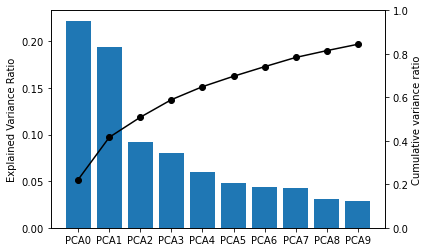

In [219]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

### Ic

In [225]:
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
# drop nan rows
pipeline.fit(df_Ic.dropna())

pca_number = [f'PCA{num}' for num in range(n_components)]
df_pca = pd.DataFrame(pipeline['pca'].components_, columns=df_Ic.columns)
df_pca.index = pca_number
df_pca.style\
    .background_gradient(cmap='bwr_r',vmin=-1, vmax=1, axis=None)\
    .format("{:.2}")

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
PCA0,0.12,0.14,0.16,0.12,0.14,0.2,0.21,0.23,0.23,0.24,0.26,0.25,0.26,0.28,0.29,0.28,0.28,0.24,0.22,0.2
PCA1,-0.13,-0.25,-0.33,-0.33,-0.31,-0.28,-0.19,-0.22,-0.18,-0.16,-0.085,0.0062,0.12,0.15,0.23,0.22,0.24,0.27,0.23,0.24
PCA2,-0.43,-0.51,-0.25,0.22,0.4,0.36,0.28,0.056,-0.053,-0.18,-0.15,-0.086,-0.0076,0.081,0.025,0.0093,-0.00023,-0.013,0.075,0.05
PCA3,-0.12,0.096,0.36,0.47,0.26,-0.14,-0.36,-0.41,-0.31,-0.23,-0.0046,0.15,0.15,0.14,0.083,0.11,0.099,-0.013,-0.057,-0.064
PCA4,0.39,0.22,0.11,0.099,0.15,0.14,0.049,0.018,-0.11,-0.25,-0.37,-0.39,-0.29,-0.18,-0.046,0.063,0.16,0.26,0.34,0.23
PCA5,0.54,0.05,-0.29,-0.21,0.14,0.25,0.2,-0.13,-0.39,-0.24,0.015,0.27,0.26,0.17,0.0091,-0.045,-0.12,-0.14,-0.12,-0.1
PCA6,-0.1,0.025,-0.022,0.038,0.046,-0.018,-0.024,-0.03,-0.16,-0.064,0.37,0.39,-0.094,-0.28,-0.24,-0.28,-0.24,0.04,0.4,0.47
PCA7,-0.3,0.2,0.23,-0.15,-0.2,0.069,0.22,0.17,-0.1,-0.31,-0.12,0.2,0.11,0.047,-0.081,-0.19,-0.023,0.42,0.21,-0.49
PCA8,-0.18,0.13,0.31,-0.011,-0.32,-0.0025,0.3,0.14,-0.084,-0.29,-0.18,-0.083,0.2,0.089,0.077,0.04,-0.13,-0.25,-0.3,0.53
PCA9,0.21,-0.097,-0.15,0.28,0.0095,-0.34,-0.14,0.23,0.36,-0.16,-0.31,0.034,0.41,0.15,-0.061,-0.25,-0.18,-0.15,0.31,-0.017


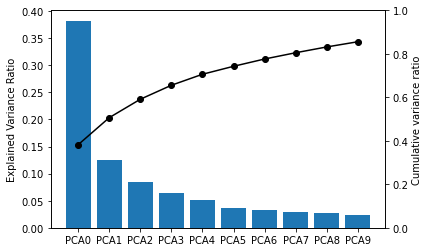

In [226]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

## Sampling rate = 0.1m

In [227]:
bins = 200
min_depth = 0
max_depth = 20
statistic = 'mean'
# mean, std, median, count, sum, min, max, user-defined function
binned_qc1ncs = []
binned_Ic = []
for ID in tqdm(df.NZGDID.unique()):
    binned_qc1ncs.append(binned_statistic(df.depth[df.NZGDID==ID], df.qc1ncs[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)
    
    binned_Ic.append(binned_statistic(df.depth[df.NZGDID==ID], df.Ic[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)

  0%|          | 0/1702 [00:00<?, ?it/s]

### qc1ncs

920 rows remain in qc1ncs dataframe after dropna
920 rows remain in Ic dataframe after dropna


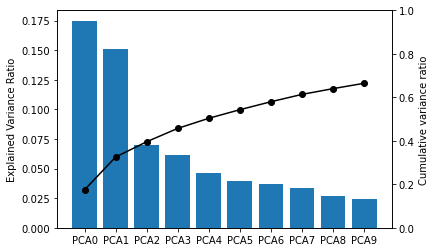

In [233]:
columns = np.linspace(min_depth, max_depth, bins, endpoint=False).astype('str')
df_qc1ncs = pd.DataFrame(data=binned_qc1ncs, columns=columns)
print(f'{len(df_qc1ncs.dropna())} rows remain in qc1ncs dataframe after dropna')

df_Ic = pd.DataFrame(data=binned_Ic, columns=columns)
print(f'{len(df_Ic.dropna())} rows remain in Ic dataframe after dropna')
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
# drop nan rows
pipeline.fit(df_qc1ncs.dropna())

pca_number = [f'PCA{num}' for num in range(n_components)]
df_pca = pd.DataFrame(pipeline['pca'].components_, columns=df_qc1ncs.columns)
df_pca.index = pca_number
df_pca.style\
    .background_gradient(cmap='bwr_r',vmin=-1, vmax=1, axis=None)\
    .format("{:.2}")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

### Ic

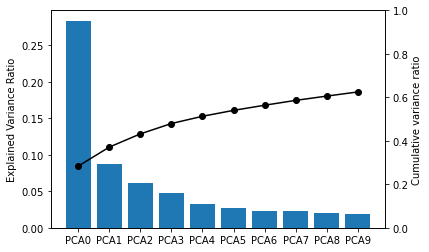

In [232]:
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
# drop nan rows
pipeline.fit(df_Ic.dropna())

pca_number = [f'PCA{num}' for num in range(n_components)]
df_pca = pd.DataFrame(pipeline['pca'].components_, columns=df_Ic.columns)
df_pca.index = pca_number
df_pca.style\
    .background_gradient(cmap='bwr_r',vmin=-1, vmax=1, axis=None)\
    .format("{:.2}")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

## Sampling rate = 0.02m

In [251]:
bins = 1000
min_depth = 0
max_depth = 20
statistic = 'mean'
# mean, std, median, count, sum, min, max, user-defined function
binned_qc1ncs = []
binned_Ic = []
for ID in tqdm(df.NZGDID.unique()):
    binned_qc1ncs.append(binned_statistic(df.depth[df.NZGDID==ID], df.qc1ncs[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)
    
    binned_Ic.append(binned_statistic(df.depth[df.NZGDID==ID], df.Ic[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)

  0%|          | 0/1702 [00:00<?, ?it/s]

### q1cncs

430 rows remain in qc1ncs dataframe after dropna
430 rows remain in Ic dataframe after dropna


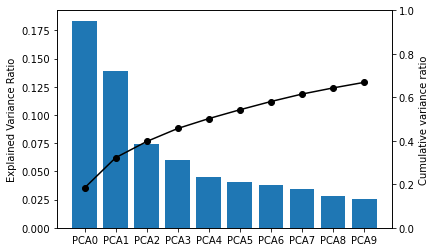

In [252]:
columns = np.linspace(min_depth, max_depth, bins, endpoint=False).astype('str')
df_qc1ncs = pd.DataFrame(data=binned_qc1ncs, columns=columns)
print(f'{len(df_qc1ncs.dropna())} rows remain in qc1ncs dataframe after dropna')

df_Ic = pd.DataFrame(data=binned_Ic, columns=columns)
print(f'{len(df_Ic.dropna())} rows remain in Ic dataframe after dropna')
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
# drop nan rows
pipeline.fit(df_qc1ncs.dropna())

pca_number = [f'PCA{num}' for num in range(n_components)]
df_pca = pd.DataFrame(pipeline['pca'].components_, columns=df_qc1ncs.columns)
df_pca.index = pca_number
df_pca.style\
    .background_gradient(cmap='bwr_r',vmin=-1, vmax=1, axis=None)\
    .format("{:.2}")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

### Ic

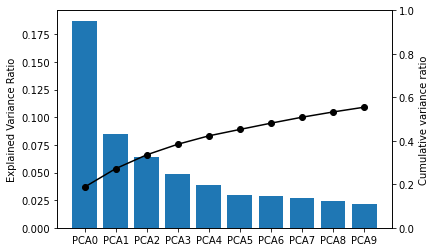

In [253]:
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
# drop nan rows
pipeline.fit(df_Ic.dropna())

pca_number = [f'PCA{num}' for num in range(n_components)]
df_pca = pd.DataFrame(pipeline['pca'].components_, columns=df_Ic.columns)
df_pca.index = pca_number
df_pca.style\
    .background_gradient(cmap='bwr_r',vmin=-1, vmax=1, axis=None)\
    .format("{:.2}")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

## Autoencoder